# Milestone 3 Assignment - Capstone Project

## Author - Logan Downing
Datasci 420  
Aug 23, 2018

![](http://drivendata.materials.s3.amazonaws.com/pumps/pumping.jpg)
# Capstone Project  - Water Security in Tanzania


Data from the Tanzanian Ministry of Water reveals the working state of thousands of water pumps across that country. The data include a plethora of features including pump age, type of management, cost of water and water source. The working state of each pump is included. 

**Business problem**  
The challenge is to determine, given the characteristics of each water pump, whether you can predict which pumps are faulty. "A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania." (DrivenData.org)

## Milestone 3
In this final milestone, we finish the optimization of our best predictive model from Milestone 2, and analyze its performance. 

### Model improvement plan
In the previous milestone we created the following model improvement plan, which we'll execute in this milestone.

#### 1. Hyperparameter tuning
We conduct a grid search over sets of hyperparameters to find a balance in performance between training and unseen data.

#### 2. Apply boosting algorithms
Try to improve performance through two approaches that focus on the modeling errors from previous iterations. We'll try Gradient Boosted Decision Trees and AdaBoost adaptive boosting using Decision Treee.

#### 3. Determine best production model
Using the results from the previous steps, we arrive at our final predictive model. Separately we'll create the final presentation of this capstone project, summarizing the findings and making recommendations.


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import libraries here for later use
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc,roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from time import time
time00=time() # overall timing of entire notebook (see end)

# Acquire data
In this first step we read in the data produced during the previous milestones. They have already been scaled and transformed. Please refer to earlier milestones for details on this work.

In [4]:
# data are located locally. this dataset is the outcome of M02 assignment.
f = 'data/LoganDowning-M02-dataset.csv'
df = pd.read_csv(f, header=0, index_col=None)
df.head()

gps_height  population  public_meeting  permit  status_group       age  \
0   -0.309077    0.212034               0       1             1  2.144554   
1   -0.344261    1.000000               1       1             0 -0.979373   
2   -0.344261    1.000000               0       1             1  2.144554   
3   -0.328268    0.000000               0       1             1  2.144554   
4   -0.344261    0.040115               1       1             1 -0.819172   

     precip  basin_Internal  basin_Lake Nyasa  basin_Lake Tanganyika  \
0  0.923499               0                 0                      1   
1  0.923499               0                 0                      1   
2  0.923499               0                 0                      1   
3  0.923499               0                 0                      1   
4  0.923499               0                 0                      1   

     ...     payment_unknown  quality  quantity  source_borehole  source_dam  \
0    ...                   0        1         0                0           0   
1    ...                   0        1         1                0           0   
2    ...                   0        1         0                0           0   
3    ...                   0        1         0                0           0   
4    ...                   1        1         0                0           0   

   source_rainwater harvesting  source_river/lake  source_shallow well  \
0                            0                  1                    0   
1                            0                  0                    1   
2                            0                  1                    0   
3                            0                  1                    0   
4                            0                  0                    0   

   source_spring    region  
0              0  0.038785  
1              0  0.038785  
2              0  0.038785  
3              0  0.038785  
4              1  0.038785  

[5 rows x 36 columns]

In [5]:
# data are already scaled, transformed, etc.

In [6]:
# feature engineering step
# found these six fields to be most predictive from M02
best_features = [
    'type_other',
    'quantity',
    'age',
    'region',
    'payment_never pay',
    'gps_height'
]

# subsequent Random Forest analysis suggests the following two fields 
# are also predictive:
best_features.append('precip')
best_features.append('population')

** Divide our data into test, validate and train **

In [7]:
# get a test, validate, train split
X = df.drop('status_group',axis=1) # status_group is the outcome variable
y = df.status_group

# first split out a test set (X_test, y_test)
X_rest,X_test,y_rest,y_test = train_test_split(X,y,test_size=.2,random_state=101)

# now split a validation set out of the remaining data
X_train,X_validate,y_train,y_validate = train_test_split(X_rest,y_rest,test_size=.25,random_state=102)

In [8]:
# check on the sizes of each of the three sets of data
print("Size of training: {} ({}% of total)".format(  len(X_train), round(len(X_train)/len(X)*100,0)       ))
print("Size of validate: {} ({}% of total)".format(  len(X_validate), round(len(X_validate)/len(X)*100,0)       ))
print("Size of test: {} ({}% of total)".format(  len(X_test), round(len(X_test)/len(X)*100,0)       ))

Size of training: 21697 (60.0% of total)
Size of validate: 7233 (20.0% of total)
Size of test: 7233 (20.0% of total)


# Benchmark model
In Milestone 2 we discovered that the Random Forest approach had the best promise to predict the working state of water pumps. In this section we'll create a single CART model for benchmarking. We use largely default hyperparameters (tuning comes later).

In [9]:
# apply a baseline CART for benchmarking
clf_rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=200, oob_score=True)

#### Estimate accuracy on training data
Estimate the accuracy of a baseline Random Forest based on the out-of-bag sampling that happens during the fit stage.  

In [10]:
clf_rf.fit(X_train,y_train)

# estimate of performance on the training dataset:
print("Estimate of accuracy based on out-of-bag samples: {:.2f}".format(clf_rf.oob_score_))

Estimate of accuracy based on out-of-bag samples: 0.82


#### Estimate accuracy on validation data
And compare that to the performance based on the validation dataset.

In [11]:
def perf_summary(y_true,y_pred,y_prob=None,dataset=''):   

    # y_true = actual class label
    # y_pred = predicted class label
    # y_prob = probability of class membership, used in auc (send in null for n/a)
    # dataset = a label, e.g., "training" or "validation" that will be printed out
    
    # classification report:
    print("Classification report for {} data:\n".format(dataset))
    print(classification_report(y_true,y_pred))

    # accuracy:
    print("Overall accuracy: {:.2f}".format(accuracy_score(y_true,y_pred)))
    
    # auc:
    if y_prob is not None:
        fpr,tpr,th = roc_curve(y_true,y_prob,pos_label=1)
        auc_score = auc(fpr,tpr)
        print("AUC score: {:.2f}".format(auc_score))

y_prob = clf_rf.predict_proba(X_validate)[:,1] # prob of class 1
y_pred_valid = clf_rf.predict(X_validate)
perf_summary(y_validate,y_pred_valid,y_prob,dataset='validation')

Classification report for validation data:

             precision    recall  f1-score   support

          0       0.85      0.88      0.86      4381
          1       0.80      0.76      0.78      2852

avg / total       0.83      0.83      0.83      7233

Overall accuracy: 0.83
AUC score: 0.90


#### Estimate variance of accuracy score on unseen data
Using cross-validation on the combined training + validation data, let's get an estimate for the variation in accuracy score of the benchmark model.

In [12]:
# apply cross-validation to the "rest" data, which is training + validation
scores = cross_val_score( clf_rf,X_rest,y_rest,scoring='accuracy',cv=5 )
print("Average accuracy score: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()*2)) # at the 95% conf interval (2 sigma)

Average accuracy score: 0.83 +/- 0.01


### Baseline model summary of performance
Using a basic Random Forest model with untuned hyperparameters, we can get about an 82% accuracy rate on both the training data and the validation data. That the score is similar for both train and validation is important, since it implies our Random Forest is not overfitting on training. Note that in previous milestone we incorrectly estimated training fit using the model's predict method on the training data itself. That incorrect approach artificially elevated the training fit and incorrectly implied training overfit. [https://stats.stackexchange.com/questions/66543/random-forest-is-overfitting]



# Hyperparameter tuning
Let's now see whether we can improve on the basic Random Forest by selecting hyperparameters. We'll run a grid search over a reasonable set of parameters, measure the changes in performance, and pick an optimum set.

In [13]:
m = RandomForestClassifier(n_jobs=-1)

params = {
    'max_depth':[5,20,None],
    'n_estimators':[20,50,80,100],
    'min_samples_split':[2,5,8,12,15],
    'criterion':['entropy'],
    'min_samples_leaf':[2,3,4,5],
    'max_features':['auto',5,10,15,20,len(X.columns)]
}
time0=time()

# grid search using multiple folds:
from sklearn.metrics import make_scorer,f1_score,recall_score
#scorer = make_scorer(f1_score,average='binary') # just pos class

# for our performance metric let's choose the Recall of the positive class.
# this will emphasize the importance of identifying all the non-working pumps (class 1)
# at the cost of misidentifying some working ones.
scorer = make_scorer(recall_score,average='binary') # just recall of the pos class

# uncomment next lines to repeat the grid search:
#gs = GridSearchCV( m, scoring=scorer ,param_grid=params, cv=5, n_jobs=-1, return_train_score=True, verbose=1 )
#gs.fit(X_rest,y_rest)
# save results in a pickle:
#pd.DataFrame( gs.cv_results_).to_pickle('data/LoganDowning-M03-grid-search.pkl')
#print("Completed in {:.1f} seconds".format(time()-time0))

#Here's what grid search output:
#Fitting 5 folds for each of 1440 candidates, totalling 7200 fits#
#
#[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.0s
#[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
#[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.8min
#[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.6min
#[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 15.0min
#[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 25.9min
#[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 752.9min
#[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 807.3min
#[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 838.6min
#[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 904.2min
#[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 939.6min
#[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 1012.8min
#[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 1013.2min finished
#Completed in 60798.0 seconds


I've already run the grid search overnight, and saved out the data into this pickle.

In [14]:
# load results from pickle, saving you a 1013 minutes of crunching!
df_perf = pd.read_pickle('data/LoganDowning-M03-grid-search.pkl')

In [15]:
# analyze results
show_fields = ["param_" + ix for ix in params.keys()]
show_fields += ['mean_test_score','mean_train_score','rank_test_score']
df_perf.sort_values('mean_test_score',ascending=False)[show_fields][:9]

param_max_depth param_n_estimators param_min_samples_split  \
1282            None                 80                       2   
1206            None                 80                       5   
1202            None                 80                       2   
1203            None                100                       2   
1362            None                 80                       2   
1287            None                100                       5   
1204            None                 20                       5   
1281            None                 50                       2   
1201            None                 50                       2   

     param_criterion param_min_samples_leaf param_max_features  \
1282         entropy                      2                 20   
1206         entropy                      2                 15   
1202         entropy                      2                 15   
1203         entropy                      2                 15   
1362         entropy                      2                 35   
1287         entropy                      2                 20   
1204         entropy                      2                 15   
1281         entropy                      2                 20   
1201         entropy                      2                 15   

      mean_test_score  mean_train_score  rank_test_score  
1282         0.754901          0.927153                1  
1206         0.754124          0.908498                2  
1202         0.753692          0.916422                3  
1203         0.752656          0.916249                4  
1362         0.752310          0.940992                5  
1287         0.752224          0.919423                6  
1204         0.752224          0.903036                7  
1281         0.752224          0.925771                8  
1201         0.751965          0.914025                9

We concentrate on the mean_test_score from the grid search. (Note that the mean_train_score is produced via the predict() method using the training data, which is inappropriate for Random Forests as already discussed.)

Plot out results and select best values

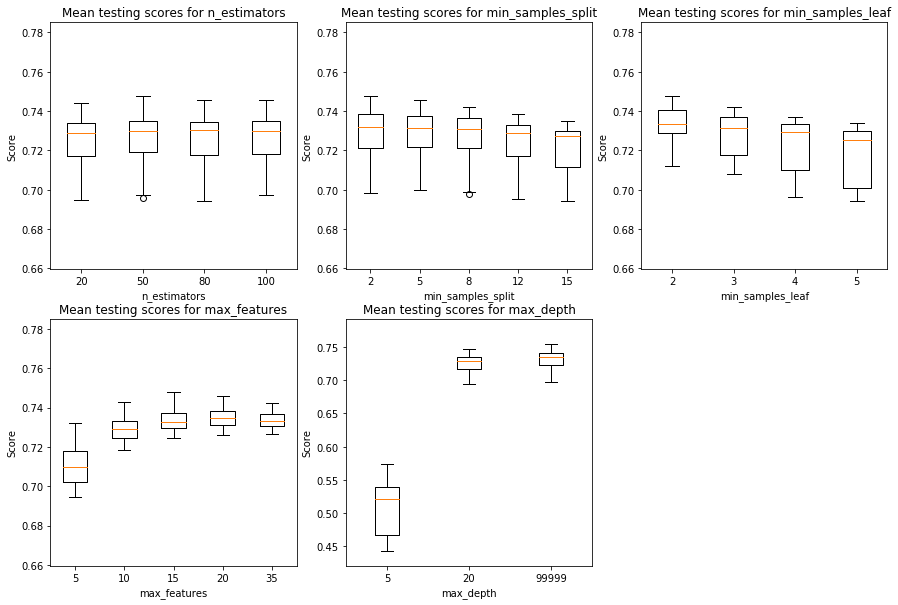

In [16]:
# examine each of the five parameters in result space for test:
#    'max_depth':[5,20,None],
#    'n_estimators':[20,50,80,100],
#    'min_samples_split':[2,5,8,12,15],
#    'min_samples_leaf':[2,3,4,5],
#    'max_features':['auto',5,10,15,20,len(X.columns)]

def draw_test_scores(df,field,vals):

    # fields are prefixed by 'param_' in the results dataframe
    param = 'param_' + field

    # min/max axis values
    ymin = df.mean_test_score.min()   * .95
    ymax = df.mean_test_score.max()   * 1.05

    #plt.figure(figsize=(12,5))
    plt.boxplot([
        df[df[param]==ix]['mean_test_score'] for ix in vals
    ])      
    plt.ylim((ymin,ymax))
    plt.ylabel("Score")
    plt.xticks( range(1,len(vals)+1), vals )
    plt.xlabel(field or "")
    plt.title('Mean testing scores for {}'.format(field))

#max_depth of 5 gives terrible results on both train and test. discard it when plotting

plt.figure(figsize=(15,10))

# max_depth
plt.subplot(2,3,1)
draw_test_scores(df_perf[df_perf.param_max_depth>5],field='n_estimators',vals=[20,50,80,100])

# min_samples_split
plt.subplot(2,3,2)
draw_test_scores(df_perf[df_perf.param_max_depth>5],field='min_samples_split',
            vals=[2,5,8,12,15])

# min_samples_leaf
plt.subplot(2,3,3)
draw_test_scores(df_perf[df_perf.param_max_depth>5],field='min_samples_leaf',
            vals=[2,3,4,5])

# max_features
plt.subplot(2,3,4)
draw_test_scores(df_perf[df_perf.param_max_depth>5],field='max_features',
            vals=[5,10,15,20,len(X.columns)])

# max_depth
plt.subplot(2,3,5)
draw_test_scores(df_perf.fillna(99999),field='max_depth',
            vals=[5,20,99999])


The charts above show the variation in mean train scores as hyperparameters move through their range. We can immediately see useful trends:

* n_estimators has a modest effect on scoring. We'll select 20 for computational efficiency.

* min_samples_split has a modest effect on the test set, but can help combat overfitting  in the training set. Let's take min_samples_split of 12.

* min_samples_leaf has a small effect on testing scores, and can also  reduce overfitting on the training set. Let's take min_samples_leaf = 5.

* Increasing max_features helps improve both train and test up to about max_features=15.

* Finally, max_depth improves training and test scores but not much beyond 20. We'll take max_depth=20.




### Summary of best hyperparameters
Here are the best values for hyperparameters for our Random Forest classifier, based on the grid search.  

n_estimators = 20  
min_samples_leaf = 5  
min_samples_split = 12  
max_features = 15  
max_depth = 20

# Best Random Forest model
Now that we have our best hyperparameters, let's create the "best" Random Forest model using them. Then we'll evaluate its performance. 

In [17]:
# apply to test for unbiased evaluation
m_best = RandomForestClassifier(n_jobs=-1,criterion='entropy',
                                min_samples_leaf=5,
                                max_features=15,
                                min_samples_split=12,
                                n_estimators=20,
                                max_depth=20)

In [18]:
# fit on training + validation
m_best.fit(X_rest,y_rest)

# predict on test
y_pred=m_best.predict(X_test)
y_prob=m_best.predict_proba(X_test)[:,1]

In [19]:
perf_summary(y_test,y_pred,y_prob,"Best Random Forest")

Classification report for Best Random Forest data:

             precision    recall  f1-score   support

          0       0.83      0.90      0.86      4353
          1       0.82      0.73      0.77      2880

avg / total       0.83      0.83      0.83      7233

Overall accuracy: 0.83
AUC score: 0.91


#### Performance of best Random Forest
The best Random Forest modeling produces an F1-score of 77%, with a recall of 73% and a solid 82% on precision. The overall accuracy is 0.83.

We note that the "best" Random Forest matches up pretty well with the baseline model. That's curious, as we'd expect the hyperparmeters to have improved the performance at least somewhat.


### Compare to Random Forest using reduced feature set
In the previous milestone we came up with a list of eight "best features" that are presumably most predictive. Let's compare the results of our best Random Forest against this reduced-feature set model.

In [20]:
# model using optimized hyperparameters. we have to omit max_features since we only 
# have 8 features in the reduced feature set.
clf = RandomForestClassifier(
                    n_jobs=-1,criterion='entropy',random_state=8,
                    min_samples_leaf=5,
                    #max_features=15,
                    min_samples_split=12,
                    n_estimators=20,
                    max_depth=20)

In [21]:
# fit against train + validate
clf.fit(X_rest[best_features],y_rest)

# predict on test
y_pred=clf.predict(X_test[best_features])
y_prob=clf.predict_proba(X_test[best_features])[:,1]

** Performance of reduced feature set model **

In [22]:
perf_summary(y_test,y_pred,y_prob,"Reduced-features Random Forest")

Classification report for Reduced-features Random Forest data:

             precision    recall  f1-score   support

          0       0.82      0.89      0.85      4353
          1       0.81      0.71      0.76      2880

avg / total       0.82      0.82      0.82      7233

Overall accuracy: 0.82
AUC score: 0.89


It turns out using the reduced set of features does not improve the model. Overall accuracy hovers just slightly lower, but for all practical purposes the values are just about the same.

# Gradient Boosted Decision Tree
Let's now see if we can squeeze out more performance by boosting. We'll use GBDT which iteratively models the errors from previous iterations.

In [23]:
# let's try Gradient Boost Decision Tree and see if we improve
m = GradientBoostingClassifier(
                    min_samples_leaf=5,
                    max_features=15,
                    min_samples_split=12,
                    n_estimators=20,
                    max_depth=20 )
# fit on train + validate:
m.fit(X_rest,y_rest)

# predict on test:
y_prob = m.predict_proba(X_test)[:,1]
y_pred = m.predict(X_test)

In [24]:
# evaluate model using scoring
perf_summary(y_test,y_pred,y_prob,dataset='Gradient Boosted')

Classification report for Gradient Boosted data:

             precision    recall  f1-score   support

          0       0.84      0.90      0.87      4353
          1       0.83      0.74      0.78      2880

avg / total       0.84      0.84      0.83      7233

Overall accuracy: 0.84
AUC score: 0.91


The GBDT approach adds a sliver of predictive power to most categories of performance, including overall accuracy. F1-score for the positive class rises to 79% (from 77%), and overall acccuracy increased by 1%, as compared to our "best" model.

The slight performance boost provided by this enhancement might not be worth the increased compute time which is significant.

# AdaBoost
Finally, let's try one more possible enhancement, using the AdaBoost adaptive boosting algorithm. This approach iteratively models with resampling, more strongly weighing the datapoints incorrectly classified in the previous iteration.

In [25]:
# and let's run our best Decision Tree through AdaBoost, which
# iteratively fits re-weighted samples based on misclassification
from sklearn.ensemble import AdaBoostClassifier

In [26]:
m = RandomForestClassifier(n_jobs=-1,criterion='entropy',
                                min_samples_leaf=5,
                                max_features=15,
                                min_samples_split=12,
                                n_estimators=20,
                                max_depth=20)

# we'll just try a few iterations:
ada = AdaBoostClassifier(base_estimator = m, n_estimators=10)

# fit to training + validate:
ada.fit(X_rest,y_rest)

# predict on test:
y_prob = ada.predict_proba(X_test)[:,1]
y_pred = ada.predict(X_test)

In [27]:
perf_summary(y_test,y_pred,y_prob,dataset="AdaBoost")

Classification report for AdaBoost data:

             precision    recall  f1-score   support

          0       0.85      0.88      0.87      4353
          1       0.81      0.77      0.79      2880

avg / total       0.84      0.84      0.84      7233

Overall accuracy: 0.84
AUC score: 0.91


AdaBoost actually does provide predictive improvement. The recall score for detecting non-working pumps rises by 4% from the best model to 77%, the cost being just a few percent in recall from the opposite class. The algorithm runs in a moderate amount of time. All other performance measures increase a bit, making AdaBoost the preferred model for this business challenge.

### Receiver operating characteristic curve
Let's finally have a look at the sensitivity of the AdaBoost model, to get a sense of its performance over a range of thresholds.

In [28]:
fpr,tpr,th = roc_curve(y_test,y_prob,pos_label=1)

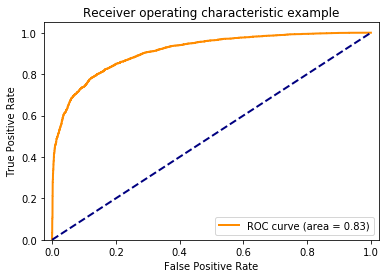

In [29]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test,y_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.025, 1.025])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
_=""

We get an AUC of about 0.83. Let's check how much variation that metric may have using cross-validation.

In [30]:
# let's try the cross-validated version with variance indicators
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
from sklearn.model_selection import StratifiedKFold,KFold
from scipy import interp
cv = StratifiedKFold(n_splits=3)
#cv = KFold(n_splits=5)
                                  
classifier = ada

tprs = []
aucs = []
f1s = []
mean_fpr = np.linspace(0, 1, 100)

In [31]:
# code below expects np arrays, not pandas dataframes
X1 = np.array(X)
y1 = np.array(y)

Train size: 24108. Test size: 12055
Finished fold 0
Finished fold 1
Finished fold 2


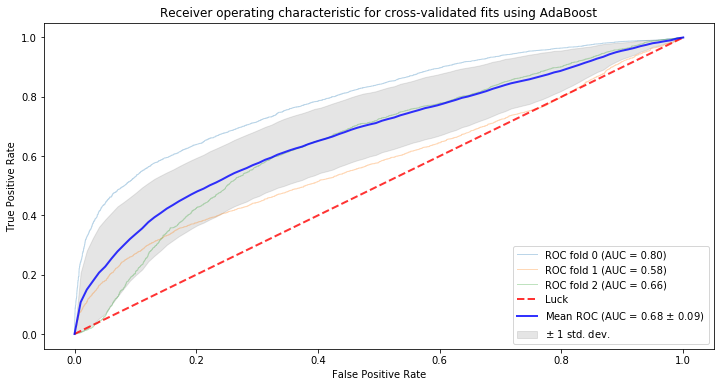

In [32]:
plt.figure(figsize=(12,6))
i = 0
for train, test in cv.split(X1, y1):
    probas_ = classifier.fit(X1[train], y1[train]).predict_proba(X1[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    f1s.append(f1_score(y1[test],classifier.predict(X1[test])))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    if i==0: print("Train size: {}. Test size: {}".format(len(train),len(test)))
    print("Finished fold",i)
     
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for cross-validated fits using AdaBoost')
plt.legend(loc="lower right")
_=''

#print("F1 scores",f1s)
#print("F1 score avg",np.mean(f1s))

Using 24,108 training datapoints and 12,055 test datapoints, the AUC averages .68 with a standard deviation of about 0.09. We're in the same ballpark with the AUC we got from the AdaBoost model was 0.83, which is just outside this range.

### Feature importances
And finally let's do a cross-check to see whether the AdaBoosted decision tree algorithm predicts a similar set of feature importances as we saw using three other feature-selection approaches.

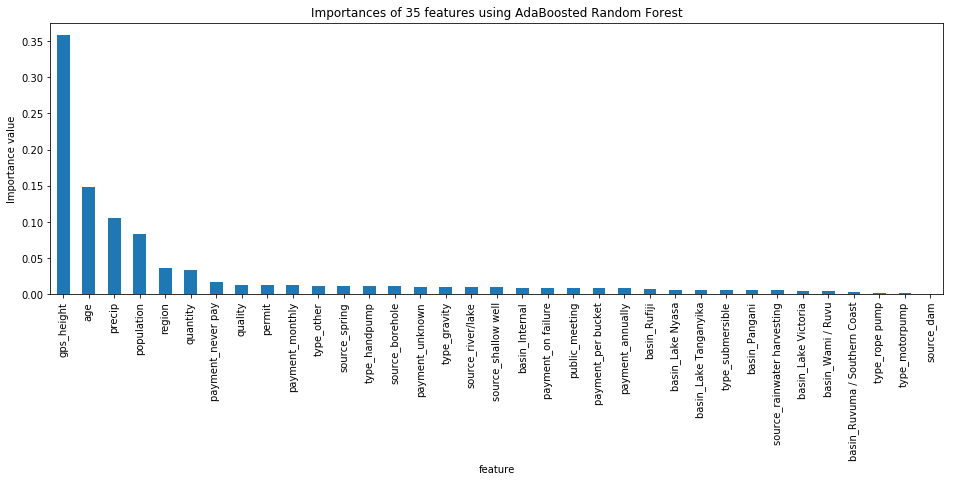

In [33]:
ax=plt.figure(figsize=(16,5)).gca()
plt.ylabel("Importance value")
plt.title("Importances of {} features using AdaBoosted Random Forest".format(len(X.columns)))
pd.DataFrame({'feature':X.columns.values, 'importance':ada.feature_importances_})\
    .set_index('feature').sort_values(by='importance',ascending=False).plot(kind='bar',ax=ax, legend=None)
_=''

The AdaBoost approach predicts these seven features as most important:

* gps_height
* age
* precip
* population
* region
* quantity
* payment_never pay

This list looks remarkably similiar to the eight features we determined (see Milestone 2) would be most predictive using three different approaches. This listing omits only type_other.

# Bonus: Visualize a tree from the Random Forest
It would be interesting to take a look at one of the trees from our Random Forest, just to get a feeling for what they look like. Obviously this is just for interest sake, since we'd never use just one tree alone from the ensemble to make any decisions.

In [34]:
# use this cell to write out the tree to file (if you want)

def create_tree_file():
    
    import graphviz
    from sklearn.tree import export_graphviz

    dotfile = open("dtree.dot", 'w')
    dot_data = export_graphviz(m_best.estimators_[7], out_file=dotfile,
                             max_depth=2,
                             feature_names=X.columns,  
                             class_names=['working','broken'],  
                             filled=True, rounded=True,  
                             special_characters=True)

    dotfile.close() # critical!

    # Convert the dot file to a png
    from subprocess import check_call
    check_call(['dot','-Tpng','dtree.dot','-o','dtree-ent.png'])

# uncomment this to write the tree to file:
#create_tree_file()

One decision tree selected at random from the Random Forest


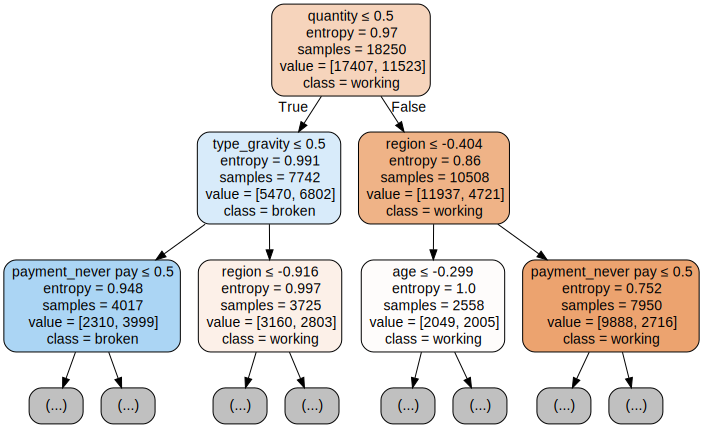

In [35]:
from IPython.display import Image,display

print("One decision tree selected at random from the Random Forest")
try:
    
    import graphviz
    from sklearn.tree import export_graphviz

    # visualization:
    dot_data = export_graphviz(m_best.estimators_[10], out_file=None,
                               max_depth=2,
                             feature_names=X.columns,  
                             class_names=['working','broken'],  
                             filled=True, rounded=True,  
                             special_characters=True)

    graph = graphviz.Source(dot_data)

    display(graph)
    
except Exception as exception:
    
    # you don't have graphviz installed. here's a screenshot instead:
    im=Image('img/dtree-ent-7-sm.png')
    print("You don't have graphviz installed. Displaying local image instead.")
    display(im)

In [36]:
# get overall time to complete entire notebook
print("Time elapsed: {:.1f} seconds".format(time()-time00))

Time elapsed: 161.9 seconds


# Wrap up
In this milestone we executed the model improvement plan created in the previous work. We started with a baseline Random Forest and used grid search to determine the best set of hyperparameters. We then checked whether the Gradient Boosted Decision Tree approach would provide any predictive improvement compared to the additional compute time (it didn't). However another boosting algorithm, AdaBoost, did get us a slight bit better outcomes at a reasonable compute cost.

## Best model: AdaBoosted Random Forest

Using the AdaBoost algorithm with our Random Forest we are able to correctly identify non-working water pumps 77% of the time (recall). Of the pumps we call out as non-working, 81% of them have accurately failed (precision). For pumps that are actually working our model misclassifies 12% as non-working. Our overall accuracy (pumps working and not) stands at 84%.

## Project conclusions and recommendations
Please see the accompanying PowerPoint presentation for a summary of this capstone project, including its final outcomes and recommendations.

<p style="text-align:center;padding:4rem 4rem;border-top:1px silver solid">Everything has to come to an end, sometime. <br><br>

--<a href="https://www.goodreads.com/quotes/398715-everything-has-to-come-to-an-end-sometime"> L. Frank Baum</a>

</p>
